In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tqdm as tqdm
import numpy as np
import tensorflow as tf
#import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
#import tensorflow_datasets as tfds

In [3]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
directory = "/kaggle/input/pizza-not-pizza/pizza_not_pizza/"
blurred_dataset = image_dataset_from_directory("/kaggle/input/blur-dataset/defocused_blurred/",
                                             labels=None,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)
clear_dataset = image_dataset_from_directory("/kaggle/input/blur-dataset/blur_dataset_scaled/sharp/",
                                             labels=None,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)

Found 350 files belonging to 1 classes.
Found 350 files belonging to 1 classes.


2022-08-20 13:06:31.291756: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
blurred_dataset = blurred_dataset.prefetch(buffer_size=AUTOTUNE)
clear_dataset = clear_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")
    self.dense2 =tf.keras.layers.MaxPooling2D((2, 2), padding="same")
    self.dense3 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")
    self.dense4 = tf.keras.layers.MaxPooling2D((2, 2), padding="same")
    #decoder
    self.dense5 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")
    self.dense6 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")
    self.dense7 = tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    x = self.dense5(x)
    x = self.dense6(x)
    x = self.dense7(x)
    return x


model = MyModel()
model.build(input_shape=(None,160, 160, 3))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  9248      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  289

In [8]:
model.compile(optimizer="adam", loss="mse")

In [12]:
data_set = tf.data.Dataset.zip( (blurred_dataset , clear_dataset) )

In [13]:
data_set

<ZipDataset shapes: ((None, 160, 160, 3), (None, 160, 160, 3)), types: (tf.float32, tf.float32)>

In [14]:
model.fit(
    data_set,
    epochs=5,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Epoch 1/5


2022-08-20 13:06:32.418074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


6/6 [==============================] - 15s 905ms/step - loss: 17183.6738
Epoch 2/5
6/6 [==============================] - 10s 898ms/step - loss: 17167.0625
Epoch 3/5
6/6 [==============================] - 10s 900ms/step - loss: 17166.2695
Epoch 4/5
6/6 [==============================] - 10s 887ms/step - loss: 17166.1094
Epoch 5/5
6/6 [==============================] - 10s 873ms/step - loss: 17166.0977


In [37]:
pred = None
for images in blurred_dataset:
  pred = model.predict(images)

In [38]:
pred.shape

(30, 160, 160, 1)

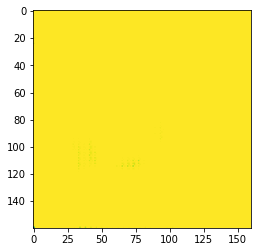

In [39]:
plt.imshow(pred[0])